# Creating TFRecord files for Pet images

In this example notebook, we will create TFRecord files from an image dataset.

The [TFRecord format](https://www.tensorflow.org/tutorials/load_data/tfrecord) is a simple format for storing a sequence of binary records. By converting our data into TFRecord records we can store the data in an efficient and convenient way. Instead of lots of small files the data is stored in a small number of large files where all data belonging to a specific sample is collected into a single record. Furthermore, the TFRecord format can be read sequentially with fast and parallel IO operations, which is especially useful when using multiple GPUs.

The image dataset used in this notebook is [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The dataset contains images of breeds of dogs and cats. There are 37 breed categories with roughly 200 images for each category.

This notebook is partly based on the tutorials ["TFRecord and tf.train.Example"](https://www.tensorflow.org/tutorials/load_data/tfrecord) and ["Creating TFRecords"](https://keras.io/examples/keras_recipes/creating_tfrecords/).

We begin with the needed imports.

In [1]:
import tensorflow as tf
import numpy as np
import random

import os
import tarfile
import re

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.7.0


## Data

In this example, the original data is stored as JPG files in a tar file `images.tar.gz` downloaded into the directory `"/media/data/pets"`. In total there are 7390 JPG images, belonging to 37 different cat and dog breed categories (e.g. *"boxer", "chihuahua"*, and *"Egyptian_Mau"*). The category of an image is specified in the filename of the image. 

In [2]:
DATADIR = "/media/data/pets"

tarfilename = DATADIR + "/images.tar.gz"
assert os.path.exists(tarfilename), "File not found: "+tarfilename

with tarfile.open(tarfilename) as tar:
    filenames = tar.getnames()
    print('Total number of JPG images:', sum(['jpg' in f for f in filenames]))
    print('First 10 files:', filenames[:10])

Total number of JPG images: 7390
First 10 files: ['images', 'images/boxer_16.jpg', 'images/chihuahua_165.jpg', 'images/pug_183.jpg', 'images/english_setter_1.jpg', 'images/chihuahua_170.jpg', 'images/english_cocker_spaniel_17.jpg', 'images/samoyed_39.jpg', 'images/Egyptian_Mau_62.jpg', 'images/samoyed_36.jpg']


## Create TFRecord files

First we define a set of helper functions to convert standard datatypes (bytes, strings, integers) to a `tf.train.Example`-compatible `tf.train.Feature`s. 

Then we define the function `create_example()` to create `tf.train.Example` messages containing all the features of each image. The used features include:
* `"image"`: image data as bytes 
* `"filename"`: original file name of the image in the input tar file
* `"classname"`: pet category of the image, extracted from the image file name
* `"classidx"`: integer index of the pet category of the image

In [3]:
def image_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def str_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_example(image, filename, classname, classidx):
    feature = {
        "image": image_feature(image),
        "filename": str_feature(filename),
        "classname": str_feature(classname),
        "classidx": int64_feature(classidx),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

We process every JPG image in the tar file and write a corresponding TFRecord entry. We split the TFRecord entries into `N_SHARDS = 10` distinct TFRecord files named `"images_XXX.tfrec"` (where `XXX` is the zero-padded shard number). 

We can store either JPG-encoded image data in the TFRecord files, or decode and preprocess the images first.
In the latter option (`STORE_DECODED_IMAGES = True`), the TFRecord files will contain serialized `tf.Tensor`s with the RGB pixel values of the images. This will make the TFRecord files larger in size, but, on the other hand, eliminate the need for image decoding when reading the image data from the TFRecord files.

The category of the image is extracted from the image file name and the categories are mapped into integer indices starting from zero.

In [4]:
N_SHARDS = 10
STORE_DECODED_IMAGES = False

tar = tarfile.open(tarfilename)
classindices = {}
shards = np.array_split(tar.getmembers(), N_SHARDS)

for i, shard in enumerate(shards):
    tfrecfilename = "images_{:03d}.tfrec".format(i)
    with tf.io.TFRecordWriter(os.path.join(DATADIR, tfrecfilename)) as writer:
        n_images = 0
        for member in shard:
            if member.name.endswith(".jpg"):
                imagedata = tar.extractfile(member).read()
                if STORE_DECODED_IMAGES:
                    imagedata = tf.image.decode_jpeg(imagedata)
                    imagedata = tf.image.resize(imagedata, [256, 256])
                    imagedata = tf.cast(imagedata, tf.uint8)
                    imagedata = tf.io.serialize_tensor(imagedata).numpy()
                n_images += 1
                classname = re.findall("^.*/(.*)_\d+.jpg$", member.name)[0]
                if not (classname in classindices):
                    classindices[classname] = len(classindices)

                example = create_example(imagedata, member.name,
                                         classname, classindices[classname])
                writer.write(example.SerializeToString())
        print("Wrote {} records in {} (shard {})".format(n_images, tfrecfilename, i))
tar.close()

Wrote 738 records in images_000.tfrec (shard 0)
Wrote 740 records in images_001.tfrec (shard 1)
Wrote 740 records in images_002.tfrec (shard 2)
Wrote 740 records in images_003.tfrec (shard 3)
Wrote 739 records in images_004.tfrec (shard 4)
Wrote 739 records in images_005.tfrec (shard 5)
Wrote 737 records in images_006.tfrec (shard 6)
Wrote 739 records in images_007.tfrec (shard 7)
Wrote 739 records in images_008.tfrec (shard 8)
Wrote 739 records in images_009.tfrec (shard 9)


We can see the produced TFRecord files on disk:

In [5]:
%%bash -s "$DATADIR"

ls -lh $1/images_???.tfrec

-rw-rw-r-- 1 cloud-user cloud-user 75M Feb 18 12:28 /media/data/pets/images_000.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 79M Feb 18 12:28 /media/data/pets/images_001.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 75M Feb 18 12:28 /media/data/pets/images_002.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 77M Feb 18 12:28 /media/data/pets/images_003.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 75M Feb 18 12:28 /media/data/pets/images_004.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 78M Feb 18 12:28 /media/data/pets/images_005.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 78M Feb 18 12:28 /media/data/pets/images_006.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 77M Feb 18 12:29 /media/data/pets/images_007.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 72M Feb 18 12:29 /media/data/pets/images_008.tfrec
-rw-rw-r-- 1 cloud-user cloud-user 76M Feb 18 12:29 /media/data/pets/images_009.tfrec


## Read data from TFRecord files

To test the validity of the produced TFRecord files, we'll now read and plot some images from them.

We define a function `load_image()` to load images from the TFRecord entries. The function first parses a `tf.train.Example` message into a dictionary mapping feature keys to `tf.Tensor`s. Here we only use the `"image"` and `"classidx"` entries in the dictionary. 

If the TFRecord files contain JPG-encoded image data, the images are decoded and preprocessed by resizing to a fixed size. Otherwise, the image `tf.Tensor` is only parsed back from the serialization, as the preprocessing has already been done.

In [6]:
def preprocess_image(image):
    if STORE_DECODED_IMAGES:
        return tf.io.parse_tensor(image, tf.uint8)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    return tf.cast(image, tf.uint8)

feature_description = {
    "image": tf.io.FixedLenFeature((), tf.string),
    "filename": tf.io.FixedLenFeature((), tf.string),
    "classname": tf.io.FixedLenFeature((), tf.string),
    "classidx": tf.io.FixedLenFeature((), tf.int64)}

def load_image(example_proto):
    ex = tf.io.parse_single_example(example_proto, feature_description)
    return (preprocess_image(ex["image"]), ex["classidx"])

Now we define out `tf.data` input pipeline. We use the `TFRecordDataset` class, which can read the data records from multiple TFRecord files. 

TFRecord files contain sequences of data records and can only be read sequentially. To randomize the order of the data samples, we both shuffle the shards and use a (small) shuffle buffer when reading the data records. 

In [7]:
train_filenames = [DATADIR+"/images_{:03d}.tfrec".format(i)
                   for i in range(N_SHARDS)]
random.shuffle(train_filenames)

train_dataset = tf.data.TFRecordDataset(train_filenames)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(128).batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

We can now plot some random images read from the resulting TFRecord files.

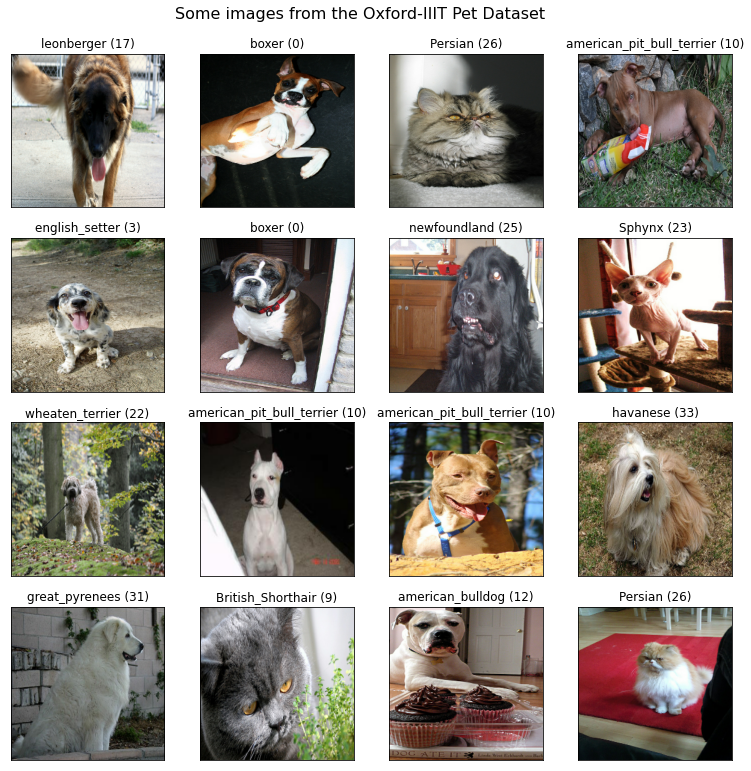

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,13))
classnames = list(classindices.keys())
for batch, labelidx in train_dataset.take(1):
    for i in range(16):    
        plt.subplot(4,4,i+1)
        plt.imshow(batch[i])
        lidx = labelidx[i].numpy()
        plt.title("{} ({})".format(classnames[lidx], lidx))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.suptitle('Some images from the Oxford-IIIT Pet Dataset', fontsize=16, y=0.93)